# Task 3: Multimodal ML – Housing Price Prediction Using Images + Tabular Data

## Goal (Objective)

  Build a multimodal machine learning model that can predict the price of a house by learning from:

1.Structured/tabular data – e.g., number of rooms, location, area (sq ft), etc.

2.Images of the house – e.g., front elevation, interior, etc.

Step 1: Mount Google Drive & Set Paths

In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set image folder path inside your Drive
IMG_DIR = '/content/drive/MyDrive/socal_pics'

# Optional: path to save intermediate progress
SAVE_PATH = '/content/drive/MyDrive/image_tabular_progress.pkl'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install and Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Sequential


Step 1: Load the Tabular Data and Preview It

In [2]:
import pandas as pd

# Load the tabular dataset
df = pd.read_csv('listings.csv')

# Show column names to verify structure
print("Columns:", df.columns.tolist())

# Clean and select numeric features only
df_clean = df[['n_citi', 'bed', 'bath', 'sqft', 'price' ]].copy()

# Drop rows with missing values
df_clean.dropna(inplace=True)

# Add image_id column assuming images are named 0.jpg, 1.jpg, ..., matching dataframe index
df_clean = df_clean.reset_index(drop=True)
df_clean['image_id'] = df_clean.index

# Show sample
print(df_clean.head())
print(" Cleaned tabular data shape:", df_clean.shape)


Columns: ['image_id', 'street', 'citi', 'n_citi', 'bed', 'bath', 'sqft', 'price']
   n_citi  bed  bath  sqft   price  image_id
0     317    3   2.0  1560  201900         0
1      48    3   2.0   713  228500         1
2     152    3   1.0   800  273950         2
3      48    3   1.0  1082  350000         3
4      55    4   3.0  2547  385100         4
 Cleaned tabular data shape: (15474, 6)


Step 3: Load First 2000 Matching Images

In [3]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# Set image folder path
IMG_DIR = "/content/drive/MyDrive/socal_pics"

# Fix image_id type and select first 4000
df_subset = df_clean.copy()
df_subset['image_id'] = df_subset['image_id'].astype(int)
df_subset = df_subset.iloc[:2000]

# Initialize lists
X_images = []
X_tabular = []
y_ids = []

for idx, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
    img_id = row['image_id']

    # 👇 Ensure correct filename (no .0)
    img_path = os.path.join(IMG_DIR, f"{int(img_id)}.jpg")

    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        img = img / 255.0
        X_images.append(img)
        X_tabular.append([row['n_citi'], row['bed'], row['bath'], row['sqft']])
        y_ids.append(img_id)
    else:
        print(f" Image not found: {img_path}")


# Convert to numpy arrays
X_images_np = np.array(X_images)
X_tabular_np = np.array(X_tabular)

print(" Loaded image data shape:", X_images_np.shape)
print(" Loaded tabular data shape:", X_tabular_np.shape)


100%|██████████| 2000/2000 [00:24<00:00, 80.47it/s] 


 Loaded image data shape: (2000, 224, 224, 3)
 Loaded tabular data shape: (2000, 4)


 Step 4: Build & Train Multimodal Model (CNN + Tabular)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model


Step 4.1: CNN Branch (Image Features)

In [6]:
image_input = Input(shape=(224, 224, 3), name='image_input')

x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)


 Step 4.2: Tabular Branch

In [7]:
tabular_input = Input(shape=(4,), name='tabular_input')  # 4 tabular features
y = layers.Dense(32, activation='relu')(tabular_input)
y = layers.Dense(16, activation='relu')(y)


Step 4.3: Combine Both Branches

In [8]:
combined = layers.concatenate([x, y])
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(32, activation='relu')(z)
output = layers.Dense(1)(z)  # Regression output

model = Model(inputs=[image_input, tabular_input], outputs=output)


In [9]:
loaded_image_ids = []  # already used during image loading


In [10]:
# Recreate df_matched
df_matched = df_clean[df_clean['image_id'].isin(loaded_image_ids)].reset_index(drop=True)

# Now get the target labels
y_np = df_matched['price'].values


In [11]:
y_np = df_clean['price'].values[:2000]  # Make sure it matches exactly


 Step 4.4: Compile and Train

In [12]:
from sklearn.model_selection import train_test_split

# Split 2000 sample data
X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_images_np, X_tabular_np, y_np, test_size=0.2, random_state=42
)


In [13]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    [X_images_np, X_tabular_np], y_np,
    epochs=5,
    batch_size=16,
    validation_split=0.2
)


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - loss: 534361374720.0000 - mae: 559018.3125 - val_loss: 7222626304.0000 - val_mae: 65840.2578
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - loss: 239263416320.0000 - mae: 346870.9688 - val_loss: 8095463936.0000 - val_mae: 72821.8672
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - loss: 203553718272.0000 - mae: 314568.3750 - val_loss: 12639587328.0000 - val_mae: 87546.3281
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - loss: 204076466176.0000 - mae: 333734.8750 - val_loss: 7636324864.0000 - val_mae: 62206.9766
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - loss: 213684224000.0000 - mae: 350635.8750 - val_loss: 11276226560.0000 - val_mae: 82159.0078


 Step 5: Model Evaluation (MAE, RMSE)

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = model.predict([X_img_val, X_tab_val])

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f" MAE: {mae:.2f}")
print(f" RMSE: {rmse:.2f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 914ms/step
 MAE: 281270.25
 RMSE: 412646.11


 Step 6: Visualize Predictions vs Actual

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 894ms/step


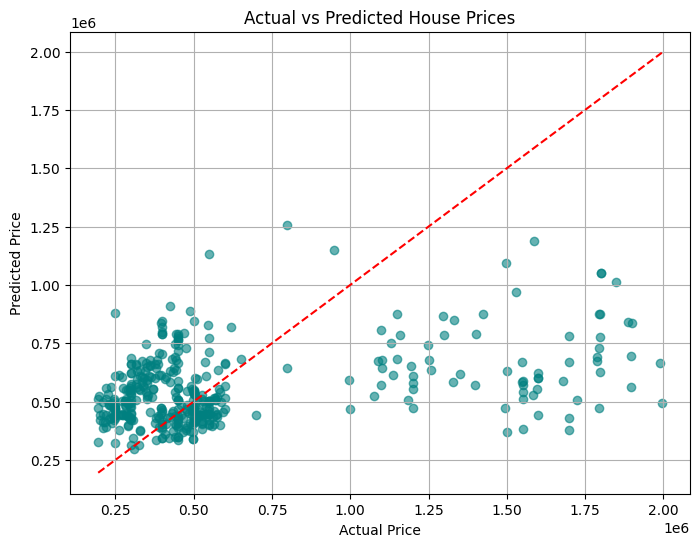

In [15]:
import matplotlib.pyplot as plt

# Predict on validation set
y_pred = model.predict([X_img_val, X_tab_val]).flatten()

# Plot predicted vs actual
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices")
plt.grid(True)
plt.show()


Step 7: Save the Trained Model

In [16]:
# Save the model in HDF5 format
model.save("multimodal_house_price_model.h5")
print(" Model saved successfully!")


 Model saved successfully!


How the Model Predicts

1. Pick one sample (e.g. index 5)

In [17]:
sample_image = X_images_np[5].reshape(1, 224, 224, 3)
sample_tabular = X_tabular_np[5].reshape(1, 4)


 2. Predict

In [18]:
predicted_price = model.predict([sample_image, sample_tabular])
print(f"Predicted Price: ${predicted_price[0][0]:,.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted Price: $389,973.88


 3. Compare with Actual

In [19]:
actual_price = y_np[5]
print(f"Actual Price: ${actual_price:,.2f}")


Actual Price: $350,000.00


predication for Custom Image Upload + Prediction

In [22]:
from google.colab import files
import cv2
import numpy as np
import tensorflow as tf

# === 1. Upload an image from your local machine ===
uploaded = files.upload()  # This will prompt a file upload dialog

# === 2. Get the uploaded file name ===
img_path = list(uploaded.keys())[0]
print(" Uploaded image:", img_path)

# === 3. Preprocess the image ===
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f" Image could not be loaded: {img_path}")

img = cv2.resize(img, (224, 224))
img = img / 255.0
img = np.expand_dims(img, axis=0)  # (1, 224, 224, 3)

# === 4. Enter your own tabular features ===
# Example format: [n_citi, bed, bath, sqft]
tabular_data = np.array([[174, 3, 2, 1257]])

# === 5. Run prediction ===
predicted_price = model.predict([img, tabular_data])
print(f" Predicted Price: ${predicted_price[0][0]:,.2f}")


Saving 1900.jpg to 1900.jpg
 Uploaded image: 1900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
 Predicted Price: $459,776.41
